14:22:11 - cmdstanpy - INFO - Chain [1] start processing
14:22:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Dhaval\anaconda3\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


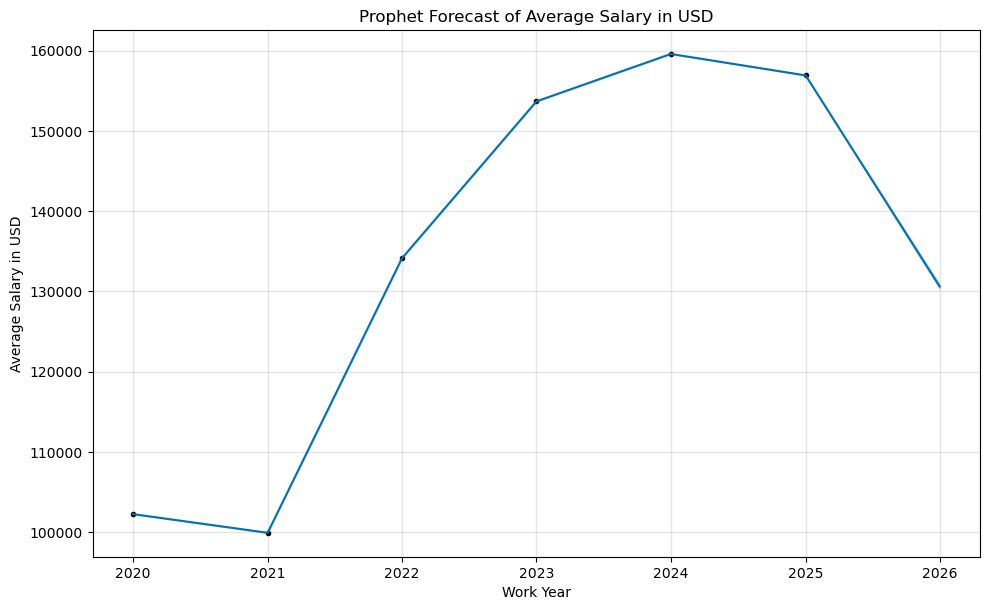

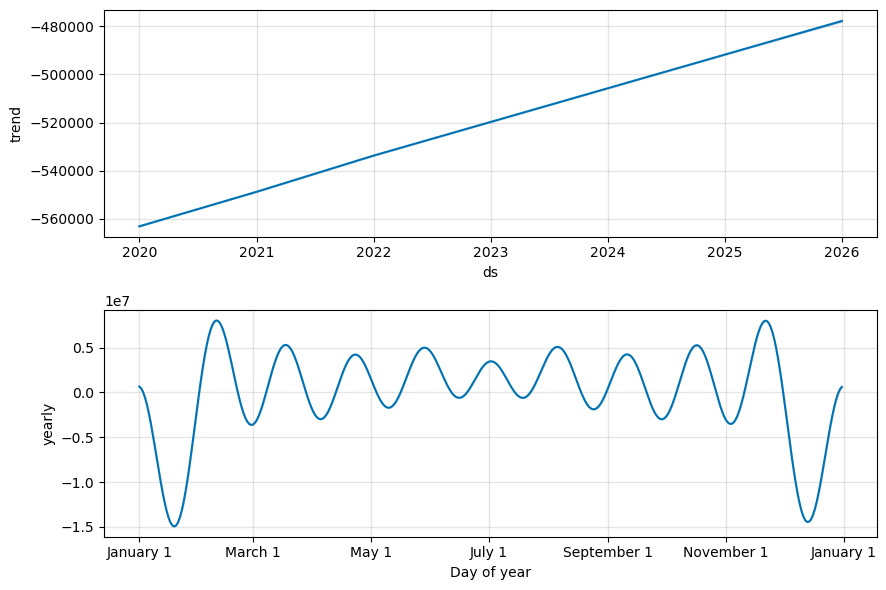

| ds                  |   yhat |   yhat_lower |   yhat_upper |
|:--------------------|-------:|-------------:|-------------:|
| 2022-01-01 00:00:00 | 134146 |       134146 |       134146 |
| 2023-01-01 00:00:00 | 153682 |       153682 |       153682 |
| 2024-01-01 00:00:00 | 159589 |       159589 |       159589 |
| 2025-01-01 00:00:00 | 156918 |       156918 |       156918 |
| 2025-12-31 00:00:00 | 130623 |       130297 |       130901 |


In [9]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df = pd.read_csv('salaries.csv')

# Prepare the data for Prophet
# Group by 'work_year' and calculate the mean of 'salary_in_usd'
df_prophet = df.groupby('work_year')['salary_in_usd'].mean().reset_index()


# Rename columns to 'ds' and 'y' as required by Prophet
df_prophet = df_prophet.rename(columns={'work_year': 'ds', 'salary_in_usd': 'y'})

# Convert 'ds' to datetime objects
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%Y')

# Create a Prophet model
model = Prophet()

# Fit the model
model.fit(df_prophet)

# Create a DataFrame for future predictions (e.g., for the next 1 year)
future = model.make_future_dataframe(periods=1, freq='Y')

# Make predictions
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title('Prophet Forecast of Average Salary in USD')
plt.xlabel('Work Year')
plt.ylabel('Average Salary in USD')
plt.show()

# Plot the components of the forecast (trend, yearly seasonality)
fig2 = model.plot_components(forecast)
plt.show()

# Display the forecasted values
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail().to_markdown(index=False))


C:\Users\Dhaval\AppData\Local\Temp\ipykernel_1532\2073690049.py:18: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_resampled = df_grouped.resample('Y').mean()
C:\Users\Dhaval\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA Forecasted Values:
 |                     | 0      |
|:--------------------|:-------|
| 2025-12-31 00:00:00 | 173306 |


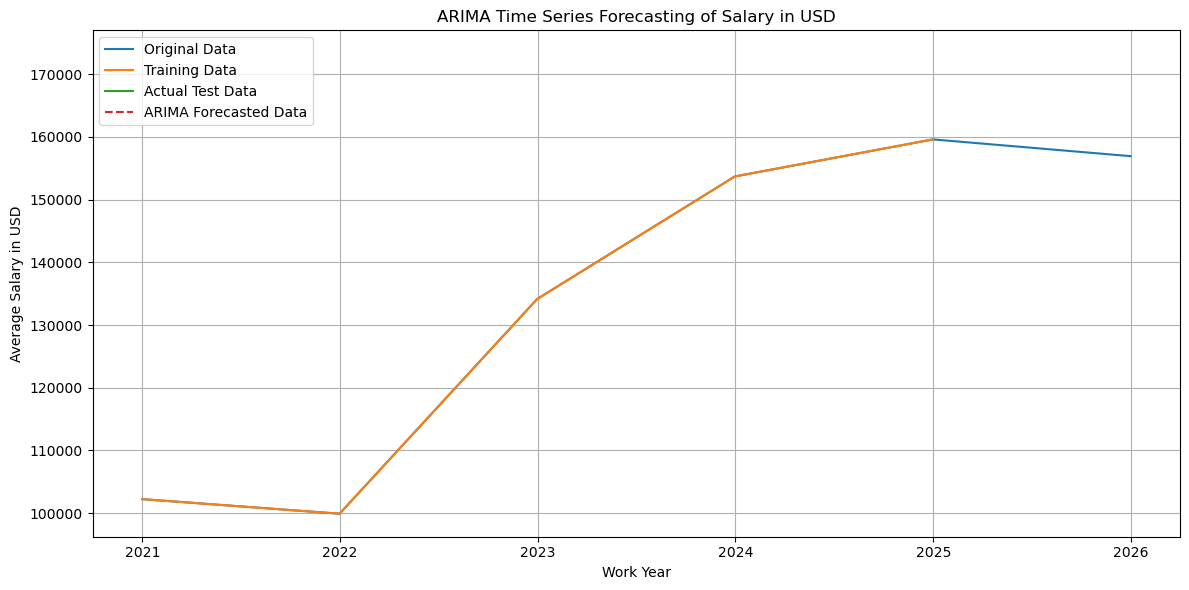

In [13]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Check if df_resampled exists from the previous run. If not, reload and prepare the data.
if 'df_resampled' not in locals():
    # Read the CSV file into a DataFrame
    df = pd.read_csv('salaries.csv')

    # Group data by work_year and calculate mean of salary_in_usd
    df_grouped = df.groupby('work_year')['salary_in_usd'].mean().reset_index()

    # Set work_year as index and convert to datetime
    df_grouped['work_year'] = pd.to_datetime(df_grouped['work_year'], format='%Y')
    df_grouped.set_index('work_year', inplace=True)

    # Resample the data to yearly frequency
    df_resampled = df_grouped.resample('Y').mean()

    # Fill any missing values with the mean of the entire series.
    df_resampled = df_resampled.fillna(df_resampled.mean())

# Split the data into training and testing sets
train_data = df_resampled[:-1]
test_data = df_resampled[-1:]

# Fit the ARIMA model
# Using common ARIMA (p,d,q) order. These values might need to be tuned for optimal performance.
# For simplicity, let's start with (5,1,0) - (AutoRegressive (AR) order, Integrated (I) order, Moving Average (MA) order)
model_arima = ARIMA(train_data['salary_in_usd'], order=(1, 1, 1))
results_arima = model_arima.fit()

# Make predictions
forecast_steps = len(test_data)
forecast_arima = results_arima.predict(start=len(train_data), end=len(train_data) + forecast_steps - 1)

# Print the ARIMA forecasted values
print("ARIMA Forecasted Values:\n", forecast_arima.to_markdown(numalign="left", stralign="left"))

# Plot the original, training, and forecasted data using Matplotlib
plt.figure(figsize=(12, 6))
plt.plot(df_resampled.index, df_resampled['salary_in_usd'], label='Original Data')
plt.plot(train_data.index, train_data['salary_in_usd'], label='Training Data')
plt.plot(test_data.index, test_data['salary_in_usd'], label='Actual Test Data')
plt.plot(forecast_arima.index, forecast_arima, label='ARIMA Forecasted Data', linestyle='--')
plt.title('ARIMA Time Series Forecasting of Salary in USD')
plt.xlabel('Work Year')
plt.ylabel('Average Salary in USD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('arima_time_series_forecast.png')